# Описание задания:

## 1) Создать численную модель расчёта компьютерной (синтезированной) голограммы плоского объекта:
а) создаёте исходный объект:

а1) берете любое изображение не очень большого размера (например, 64*64 пикселей) - это амплитуда (матрица значений амплитуды объекта;

а2) создаете фазу объекта - случайное значение от 0 до 2пи;

а3) помещаете поле в угол чёрного объектного поля бОльшего размера (например, N* N=256*256 пикселей);

б) распространяете излучение от плоскости объекта до плоскости голограммы (прямой расчёт дифракции Френеля с использованием одного быстрого преобразования Фурье); длина волны излучения = lamb=532 нм; пиксель голограммы (модельной цифровой камеры)=Pix=5,5 мкм; расстояние от объекта до голограммы = 6 * Z0=6*(N * Pix * Pix / lamb) ;

в) добавляете плоскую опорную волну;

г) находите интенсивность полученной волны (квадрат модуля суммы опорной и объектной волн);

д) квантование голограммы на 256 уровней яркости.
Полученный массив - это синтезированная (компьютерная) голограмма.

Для проверки можно численно восстановить изображение с голограммы с помощью расчёта распространения излучения от плоскости голограммы до объекта (также формула прямого расчёта дифракции Френеля с использованием одного быстрого преобразования Фурье).

Отличие формул расчёта распространения излучения для синтеза и восстановления - это то, что размер пикселя разный. При синтезе пиксель голограммы - это пиксель получаемого массива, а при восстановлении - это пиксель исходного массива. Пиксели исходного и получаемого массивов для обоих вариантов связаны через дифракционную расходимость.

Прикладываю статью, в которой подробнее описан каждый из шагов (разделы 1.1-1.2) (т.к. восстановление с амплитудной голограммы напрямую, то и аналог разделов 1.3-1.4 для амплитудного типа модулятора света).

 
## 2) Сгенерировать набор (датасет) синтезированных голограмм QR-кодов для дальнейшего обучения нейросети.

 
## 3) Используя архитектуру U-net
https://arxiv.org/abs/1505.04597
обучить сеть восстановлению QR-кодов из голограмм. Мы обычно используем Tensorflow
https://www.tensorflow.org/

 
## 4) Протестировать сеть на голограммах QR-кодов, не участвовавших в обучении

In [1]:
%matplotlib inline
import os
workpath = "..\\images"
os.chdir(workpath)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from PIL import Image
import seaborn_image as isns

image = Image.open('shamanking6464.jpg').convert('L')
#image.show(title = "leo")
amplitude = np.array(image)
phase = np.random.uniform(0, 2*np.pi, (64, 64))  # Матрица фазы объекта

# Создание поля объектного поля
N = 256
object_field = np.zeros((N, N))
object_field[1:65, 1:65] = amplitude * np.exp(1j * phase)

wavelength = 532e-9  # Длина волны излучения
pixel_size = 5.5e-6  # Размер пикселя голограммы (модельной цифровой камеры)
z_0 = 6 * (N * pixel_size * pixel_size / wavelength)  # Расстояние от объекта до голограммы

def quantize_signal(signal, levels):
    # Нормализация сигнала в диапазоне от 1 до levels - 1
    normalized_signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    # Квантование сигнала
    quantized_signal = np.round(normalized_signal * (levels - 1))
    return quantized_signal.astype(int)

def FrenelDifr(object_field, z = 6 * z_0, dx = pixel_size, lmbd = wavelength, Reconstruct = False):
    N = len(object_field)
    du = lmbd * z / (N * dx)
    x1 = np.linspace(0, N*dx, N) #Координата в поле объекта x
    y1 = np.linspace(0, N*dx, N) #Координата в поле объекта y
    
    u1 = np.linspace(0, N*du, N) #Координата в поле восстановления u 
    v1 = np.linspace(0, N*du, N) #Координата в поле восстановления v
    
    x, y = np.meshgrid(x1, y1)
    u, v = np.meshgrid(u1, v1)
    k = 2 * np.pi / wavelength
    if Reconstruct: # Восстановление голограммы
        B  = fft2((object_field*np.exp(1j * np.pi/(wavelength * z)*(x**2 + y**2))))
        B *= np.exp(1j * k * z) / (1j * wavelength * z) * np.exp(
            1j * np.pi * (u**2 + v**2) / (wavelength * z))
        return B
    else: # Синтез голограммы
        B = fft2((object_field*np.exp(1j * np.pi/(wavelength * z)*(x**2 + y**2))))
        B *= np.exp(1j * k * z) / (1j * wavelength * z) * np.exp(
            1j * np.pi * (u**2 + v**2) / (wavelength * z))
    return B
def FullReconstruct(object_field, z = 6 * z_0, dx = pixel_size, plotting = True):    
    #Синтез голограммы
    hologram_field = FrenelDifr(object_field, z = z)
    
    # Добавление плоской опорной волны
    p = 0.2 # отношение средних по пикселям интенсивностей опорной и объектной волны
    C = np.sqrt(p * np.mean(np.abs(hologram_field)**2))
    reference_wave = C * np.ones((N, N), dtype=complex)
    hologram_field += reference_wave

    # Расчет интенсивности восстановленного изображения
    intensity = quantize_signal(np.abs(hologram_field) ** 2, 256)
    rec_holo = FrenelDifr(intensity, z =  z, dx = wavelength * z / (N * pixel_size), Reconstruct = True)
    rec_image = np.abs(rec_holo) ** 2

    #rec_image = quantize_signal(rec_image,256)
    if plotting:
        fig, ax = plt.subplots(1,3, figsize = (10,8))
        ax[0].imshow(np.abs(object_field)**2)
        ax[0].set_title('Объектное поле', fontsize = 10)
        ax[1].imshow(intensity)
        ax[1].set_title('Синтезированная голограмма', fontsize = 10)
        ax[2].imshow(rec_image)
        ax[2].set_title('Восстановленное изображение', fontsize = 10)
        plt.show()
    return (object_field, intensity, rec_image)

C:\Users\user\AppData\Local\Temp\ipykernel_20812\2909936675.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  object_field[1:65, 1:65] = amplitude * np.exp(1j * phase)


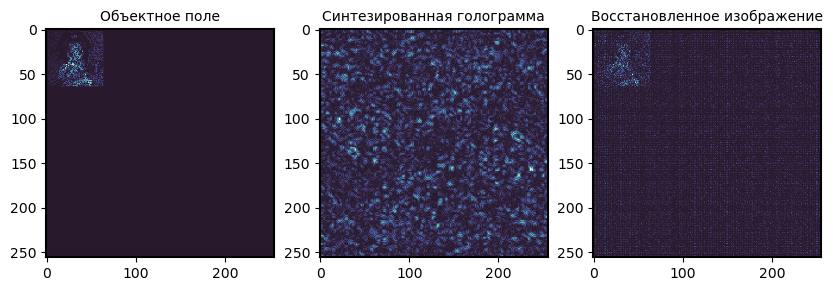

In [32]:
image, synth_holo, reconstructed_image = FullReconstruct(object_field, z = 6*z_0)

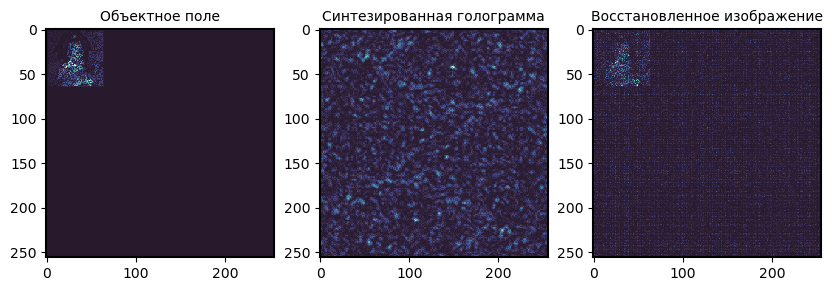

In [28]:
from IPython import display
import time
%matplotlib inline
plt.ion()  # Включаем интерактивный режим
for i in range(6, 100, 2):
    image, synth_holo, reconstructed_image = FullReconstruct(object_field, z = i*z_0)
    #display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.03)
#plt.ioff()

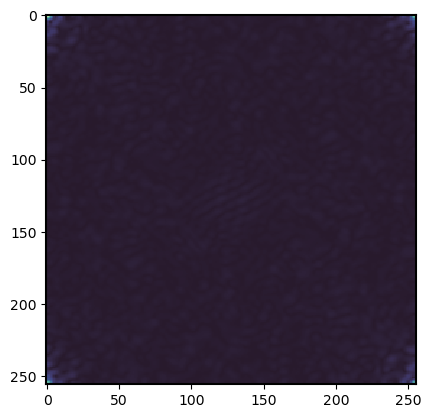

In [19]:
plt.imshow(np.abs(fft2(fftshift(np.abs(object_field)**2))))

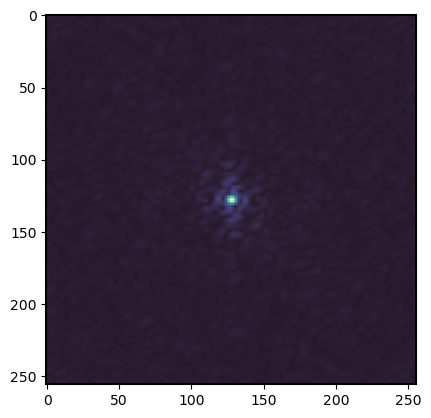

In [18]:
plt.imshow(np.abs(fftshift(fft2(ifftshift((np.abs(object_field)**2))))))